#### As shown in 'Regression with diamonds', I developed a ML model to predict diamonds price with a 98.28% accuracy. Nevertheless, sometimes it isn't enough because it doesn't deepen in the relationship between different features and how each one determines target feature value.

#### One method available to study it is SHAP values. It can break down the mechanics of any machine learning model and deep neural net to make them understandable to anyone.

#### Using the Diamonds dataset built into Seaborn, we will be predicting diamond prices using several physical measurements (diamonds dataset has been analyzed in 'Regression with diamonds' Jupyter Notebook.

## 1. Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
diamonds = pd.read_csv('diamonds.csv')
diamonds.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

## 2. Data preparation

In [3]:
diamonds.drop(['Unnamed: 0'], axis = 1, inplace=True)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# For regression
X = diamonds.drop(['price'], axis = 1)
y = diamonds[['price']]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.7+ MB


In [6]:
from sklearn.model_selection import train_test_split

# Encode cats
oe = OrdinalEncoder()
cats = X.select_dtypes(exclude=np.number).columns.tolist()

X.loc[:, cats] = oe.fit_transform(X[cats])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
26546,2.01,1.0,2.0,3.0,58.1,64.0,8.23,8.19,4.77
9159,1.01,4.0,1.0,3.0,60.0,60.0,6.57,6.49,3.92
14131,1.10,3.0,4.0,5.0,62.5,58.0,6.59,6.54,4.10
15757,1.50,1.0,1.0,3.0,61.5,65.0,7.21,7.17,4.42
24632,1.52,4.0,3.0,4.0,62.1,57.0,7.27,7.32,4.53


In [8]:
X_train.shape, y_train.shape

((43152, 9), (43152, 1))

## 3. Machine learning regressor

#### Cut, color, and clarity are categorical features. They are encoded ordinally as their orders have meaning to the context and, ultimately, the model decision.
#### As a baseline, we fit an XGBRegressor model and evaluate the performance with Root Mean Squared Error:

In [9]:
mdl = xgb.XGBRegressor(n_estimators=1000, tree_method="gpu_hist").fit(X_train, y_train)

In [10]:
from sklearn.metrics import mean_squared_error

predictions = mdl.predict(X_valid)
rmse = mean_squared_error(y_valid, predictions, squared=False)

In [11]:
rmse

562.2285741282233

## 4. SHAP and Shapley values

#### Now, let's finally work out the Shapley values for the training set.

In [12]:
# Create a tree explainer
xgb_explainer = shap.TreeExplainer(mdl, X_train, feature_names=X_train.columns.tolist())
xgb_explainer

In [13]:
%%time

# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 43144/43152 [29:33<00:00]        

Wall time: 29min 34s


In [14]:
shap_values.shape

(43152, 9)

#### Calculating Shapley values is a complex process, which is why it took 28 mins (local machine) for just 45k observations on the CPU. For large modern datasets with hundreds of features and millions of samples, the calculation can take days!!!!!. So, we turn to GPUs to calculate the SHAP values.
#### GPU support is not stable in SHAP, but we have a workaround. The predict method of the core XGBoost model has pred_contribs argument, which, when set to True, calculates SHAP values on GPUs:

In [15]:
%%time

# Shap values with XGBoost core moedl
boosted_xgb = mdl.get_booster()
shap_values_xgb = boosted_xgb.predict(xgb.DMatrix(X_train, y_train), pred_contribs=True)

Wall time: 8.64 s


#### It only needed ~8 second to calculate Shapley values for 45k samples on GPU.

In [16]:
shap_values_xgb.shape

(43152, 10)

#### What? SHAP values from the tree explainer had 9 columns but this one has 10!! Keep calm and don't panic, we can safely ignore the last column for now, as it just contains the bias term which XGBoost adds by default.

In [17]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,carat,cut,color,clarity,depth,table,x,y,z
0,7617.122559,373.794769,869.150452,-730.224976,-502.142548,318.197418,-504.129364,4764.744629,35.662621
1,1336.095459,-5.928648,446.415436,-1259.038574,-19.303692,4.820746,147.484680,-6.837951,104.616943
2,1730.954224,-21.694227,-438.860809,345.497864,6.209799,-24.847097,-6.045767,-28.468349,61.592010
3,3594.636719,-38.107620,786.397583,-1914.541626,-221.491791,-738.738831,-138.101776,1057.706543,54.508595
4,5234.298828,28.796782,483.753326,1370.826294,-139.163925,-112.466194,67.051414,1992.208374,225.866943


In [18]:
# We got the Shapley values, now let's plot them

## 5. Global feature importance with SHAP

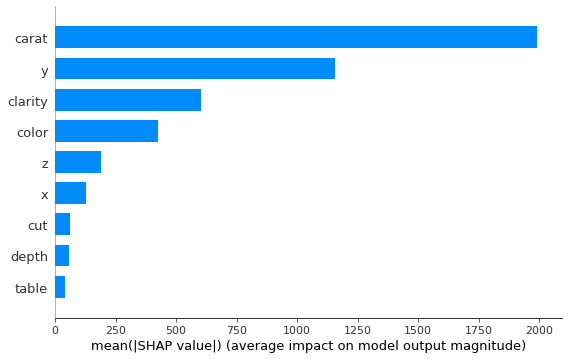

In [19]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar")

#### Carat stands out as the driving factor for a diamond's price. Reading the x-axis title below, we see that the importances are the average absolute Shapley values for a feature.

#### We don't know which feature positively or negatively influences the model yet. Let's do that with SHAP summary_plot:

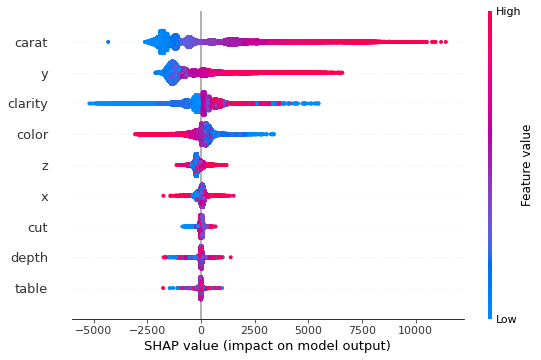

In [20]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

We see that as carat increases, its effect on the model is more positive. The same for y feature. X and z features are a bit tricky with a cluster of mixed points around the center.

We can get a deeper insight into each feature's effect on the entire dataset with dependence plots. Let's see an example and explain it later:



## 6. Feature dependence plot

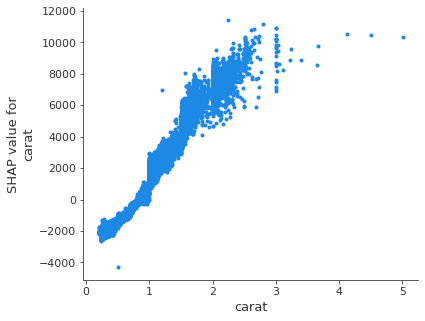

In [21]:
shap.dependence_plot("carat", shap_values_xgb, X_train, interaction_index=None)

In [22]:
#As carat increases, its SHAP value increases. If we change interaction_index parameter to auto, the plot will be coloured with
#the feature that most strongly interacts with carat.

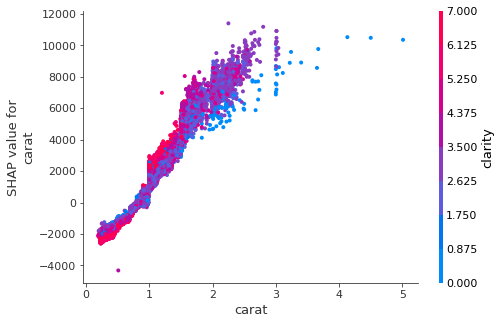

In [23]:
shap.dependence_plot("carat", shap_values_xgb, X_train, interaction_index="auto")

In [24]:
#It seems that the carat interacts with the clarity of the diamonds much stronger than other features.

## 7. Local interpretation

Finally, we get to the local interpretability section. It is all about explaining why the model got to a particular decision for a sample.
Let's choose a random diamond and its predicted price to explain:

In [25]:
random_idx = np.random.randint(len(X_train))
random_idx

24823

OK, it looks like we will be looking at the 24823th diamond in the training data.

In [26]:
%%time

# Recalculate SHAP values
shap_explainer_values = xgb_explainer(X_train, y_train, check_additivity=False)

100%|===================| 43126/43152 [26:24<00:00]        

Wall time: 26min 23s


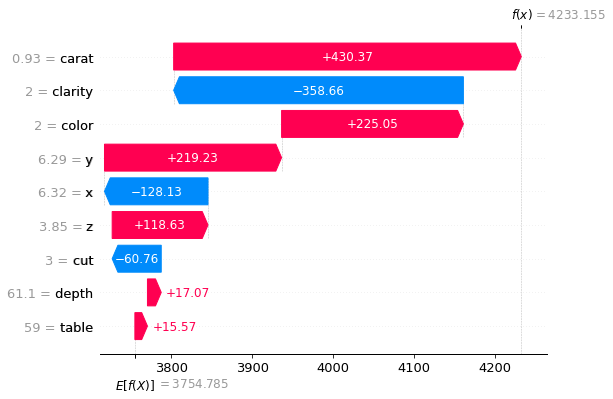

In [27]:
shap.waterfall_plot(shap_explainer_values[random_idx])

The E[f(x)] = 3754.785 is the mean prediction of diamond prices for the train set, e.g. preds.mean(). The f(x) = 4233.155 is the predicted price for the diamond.

The thin line above E[f(x)] denotes the mean prediction. The vertical axis shows the feature values of the 24823th diamond. The bars represent how each feature property shifted the price from the mean prediction. The red bars represent positive shifts; the blue bars represent negative shifts.

Let's look at another diamond.

In [28]:
random_idx2 = np.random.randint(len(X_train))
random_idx2

17465

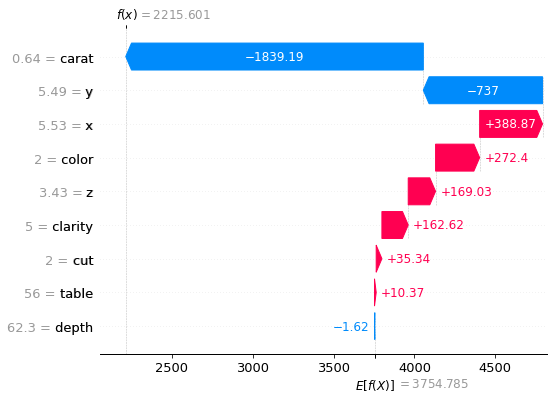

In [29]:
shap.waterfall_plot(shap_explainer_values[random_idx2])

There is another plot to explain local interpretability, force plot:

In [30]:
shap.initjs()  # don't forget to enable JavaScript

shap.force_plot(shap_explainer_values[random_idx])

This is just an ordered, organized version of waterfall plots. All negative and positive bars are grouped to either side of the predicted price. Again, the base value shows the mean price, and the bars show how much each feature property shifts that value.

In [31]:
shap.force_plot(shap_explainer_values[random_idx2])

We can see in force plot similar info than in waterfall plot. Carat is the most importance feature in the value of a diamond. Red features push predicted diamond price up while blue features decrease it.